## BitLinearLayer

Criando um código agnóstico de hardware

In [185]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Verificando se tem GPU

In [186]:
print(f"Device: {device}")
if device == "cuda":
    !nvidia-smi

Device: cuda
Sat Oct 19 12:42:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              N/A / ERR! |    158MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

Garantindo reprodutibilidade do experimento

In [187]:
DEFAULT_SEED = 42

def set_seed(seed = DEFAULT_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [188]:
set_seed()
x = torch.randn(1, 1, 4)
x, x.shape

(tensor([[[0.3367, 0.1288, 0.2345, 0.2303]]]), torch.Size([1, 1, 4]))

In [189]:
from bitnet import BitLinear

set_seed()
bit_layer = BitLinear(4, 2)
y = bit_layer(x)
print(y)

tensor([[[ 0.1261, -0.1275]]], grad_fn=<UnsafeViewBackward0>)


In [190]:
from torch.nn import Linear

set_seed()
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tensor([[[ 0.7013, -0.3801]]], grad_fn=<ViewBackward0>)


In [191]:
bit_layer.weight, linear_layer.weight

(Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True))

In [192]:
bit_layer.bias, linear_layer.bias

(Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True),
 Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True))

### Dados Sintéticos

In [193]:
from sklearn.datasets import make_circles, make_blobs

NUM_SAMPLES = 1000

class LinearlySeparableDataGenerator():
    def __init__(self):
        pass

    def generate(self,
        num_samples:int = NUM_SAMPLES, 
        random_state: int = DEFAULT_SEED):  
        X, y = make_blobs(
                       n_samples = NUM_SAMPLES, 
                       n_features=2,
                       centers=2,
                       cluster_std=2.0,
                       random_state=DEFAULT_SEED, 
                       shuffle=True
                       )
        return X, y


class NonLinearlySeparableDataGenerator():
    def __init__(self):
        pass

    def generate(self,
        num_samples:int = NUM_SAMPLES, 
        random_state: int = DEFAULT_SEED):    
        X, y = make_circles(n_samples = num_samples, 
                        noise=0.05, 
                        factor=0.6,
                        random_state=random_state, 
                        shuffle=True)
        return X, y

class MixedAndUnbalancedDataGenerator():
    def __init__(self):
        pass

    def generate(self,
                 n_samples = NUM_SAMPLES, 
                 n_features=2,
                 random_state: int = DEFAULT_SEED):
        n_samples_1 = int(NUM_SAMPLES * 0.7)
        n_samples_2 = NUM_SAMPLES - n_samples_1
        centers = [[0.0, 0.0], [2.0, 2.0]]
        clusters_std = [1.5, 0.5]
        X, y = make_blobs(
            n_samples=[n_samples_1, n_samples_2],
            centers=centers,
            cluster_std=clusters_std,
            random_state=0,
            shuffle=True,
        )
        return X, y

Selecionando dados do experimento

In [194]:
SYNTHETIC_DATA_GENERATOR = MixedAndUnbalancedDataGenerator()

X, y = SYNTHETIC_DATA_GENERATOR.generate()

In [195]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [196]:
print(f"Foram geradas um total de {len(X)} amostras!")
print("Exibindo o primeiro exemplo do dataset:")
print(f"features: [{X[0, 0]}, {X[0, 1]}]")
print(f"label: {y[0]}")

Foram geradas um total de 1000 amostras!
Exibindo o primeiro exemplo do dataset:
features: [-1.5728294849395752, -2.1300268173217773]
label: 0.0


### Split nos Dados

In [197]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=DEFAULT_SEED)

In [198]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.shape, y_train.shape)

800 800
200 200
torch.Size([800, 2]) torch.Size([800])


Visualizando os dados de Treinamento

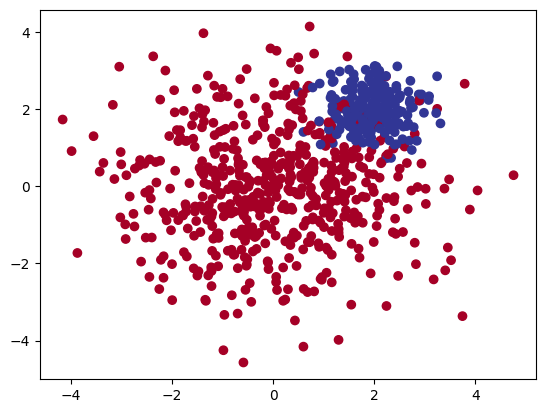

In [199]:
import matplotlib.pyplot as plt

plt.scatter(x=X_train[:, 0], y=X_train[:, 1], c = y_train, cmap=plt.cm.RdYlBu)

In [200]:
print(X_train[0], y_train[0])
print(X_test[0], y_test[0])

tensor([-2.4486, -0.1007]) tensor(0.)
tensor([-0.3104, -1.0171]) tensor(0.)


### Datasets & Dataloaders

In [201]:
from torch.utils.data import Dataset
from typing import Tuple

class CustomDataset(Dataset):
    def __init__(self, features: list, 
                        targets: list, 
                        transform = None, 
                        target_transform = None,
                        dtype = torch.float):
        super().__init__()
        self.features = features
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.dtype = dtype

    def __getitem__(self, idx):
        feature, target = self.features[idx], self.targets[idx]
        
        feature = torch.tensor(feature, 
                               dtype=self.dtype)
        target = torch.tensor(target, 
                              dtype=self.dtype)
        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            target = self.target_transform(target)
        return feature, target
    
    def __len__(self):
        return len(self.targets)

Transformando dados de treinamento e teste em datasets

In [202]:
train_dataset = CustomDataset(features = X_train, 
                              targets = y_train)

test_dataset = CustomDataset(features = X_test, 
                             targets = y_test)

len(train_dataset), len(test_dataset)

(800, 200)

Parâmetros para criação dos dataloaders, sendo o BATCH_SIZE um hiperparâmetro do treinamento

In [203]:
import os

BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

Definindo dataloaders de treinamento e teste a partir dos datasets

In [204]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False, 
                              num_workers = NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(800, 200)

In [205]:
train_batch_features, train_batch_labels = next(iter(train_dataloader))

print(len(train_batch_features), len(train_batch_labels))
print(train_batch_features[0], train_batch_labels[0])

1 1
tensor([3.2256, 1.8944]) tensor(1.)


### Arquitetura dos Modelos

Modelo base utilizando camadas nn.Linear

In [206]:
import torch.nn as nn

class BaseModel(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.name = "Base"
        self.linear_layer1 = nn.Linear(in_features=input_size, out_features=hidden_units)
        self.linear_layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.linear_layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.linear_layer4 = nn.Linear(in_features=hidden_units, out_features=output_size)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        x = self.linear_layer1(x)
        x = self.activation(x)
        x = self.linear_layer2(x)
        x = self.activation(x)
        x = self.linear_layer3(x)
        x = self.activation(x)
        x = self.linear_layer4(x)
        return x


Modelo utilizando camadas binet.BitNetLinear

In [207]:
import torch.nn as nn

class BitModel(nn.Module):
    def __init__(self, input_size:int, hidden_units:int, output_size:int):
        super().__init__()
        self.name = "Bitnet"
        self.bit_layer1 = BitLinear(in_features=input_size, out_features=hidden_units)
        self.bit_layer2 = BitLinear(in_features=hidden_units, out_features=hidden_units)
        self.bit_layer3 = BitLinear(in_features=hidden_units, out_features=hidden_units)
        self.bit_layer4 = BitLinear(in_features=hidden_units, out_features=output_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.bit_layer1(x)
        x = self.activation(x)
        x = self.bit_layer2(x)
        x = self.activation(x)
        x = self.bit_layer3(x)
        x = self.activation(x)
        x = self.bit_layer4(x)
        return x
    

In [208]:
from torchinfo import summary

In [209]:
INPUT_SIZE = 2
HIDDEN_UNITS = 5
OUTPUT_SIZE = 1

In [210]:
base_model = BaseModel(input_size=INPUT_SIZE, 
                     hidden_units=HIDDEN_UNITS, 
                     output_size=OUTPUT_SIZE
                     ).to(device)
summary(base_model, input_size=(1, 2, ))

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [1, 1]                    --
├─Linear: 1-1                            [1, 5]                    15
├─Tanh: 1-2                              [1, 5]                    --
├─Linear: 1-3                            [1, 5]                    30
├─Tanh: 1-4                              [1, 5]                    --
├─Linear: 1-5                            [1, 5]                    30
├─Tanh: 1-6                              [1, 5]                    --
├─Linear: 1-7                            [1, 1]                    6
Total params: 81
Trainable params: 81
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [211]:
bit_model = BitModel(input_size=INPUT_SIZE, 
                     hidden_units=HIDDEN_UNITS, 
                     output_size=OUTPUT_SIZE
                     ).to(device)
summary(bit_model, input_size=(1, 2, ))

Layer (type:depth-idx)                   Output Shape              Param #
BitModel                                 [1, 1]                    --
├─BitLinear: 1-1                         [1, 5]                    15
├─Tanh: 1-2                              [1, 5]                    --
├─BitLinear: 1-3                         [1, 5]                    30
├─Tanh: 1-4                              [1, 5]                    --
├─BitLinear: 1-5                         [1, 5]                    30
├─Tanh: 1-6                              [1, 5]                    --
├─BitLinear: 1-7                         [1, 1]                    6
Total params: 81
Trainable params: 81
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Treinamento dos Modelos

In [212]:
from tqdm.auto import tqdm
from torchmetrics.classification import BinaryAccuracy

def train_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          criteria: torch.nn.Module,
          metrics: BinaryAccuracy = BinaryAccuracy(),
          optimizer = None,
          device: str = device):
    
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        squeeze_dim = 0 if len(X) == 1 else 1
        y_logits = model(X).squeeze(dim = squeeze_dim)

        loss = criteria(y_logits, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_acc += metrics(torch.round(torch.sigmoid(y_logits)).cpu(), y.cpu())

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              criteria: torch.nn.Module, 
              metrics: BinaryAccuracy = BinaryAccuracy(), 
              device: str = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for test_batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            squeeze_dim = 0 if len(X) == 1 else 1
            y_logits_test = model(X_test.to(device)).squeeze(dim = squeeze_dim)
            
            test_loss += criteria(y_logits_test, y_test).item()
            test_acc += metrics(torch.round(torch.sigmoid(y_logits_test)).cpu(), y_test.cpu())

    test_loss = test_loss / len(dataloader)    
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          num_epochs: int,
          criteria: torch.nn.Module,
          metrics: BinaryAccuracy = BinaryAccuracy(),
          optimizer = None,
          device: str = device):
    
    results = {
        "model_name": str(model.name), "lr": optimizer.param_groups[0]["lr"],
        "criteria": criteria, "batch_size": train_dataloader.batch_size,
        "train_loss": [], "train_acc": [],  "test_loss": [], "test_acc": []
    }

    model.to(device)


    for epoch in tqdm(range(num_epochs)):


        # treinamento do modelo por uma época
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           criteria = criteria,
                                           metrics = metrics,
                                           optimizer = optimizer,
                                           device = device)

        # avaliando modelo nos dados de teste
        test_loss, test_acc = test_step(model = model, 
                                        dataloader = test_dataloader, 
                                        criteria = criteria, 
                                        metrics = metrics, 
                                        device = device)

        # exibindo métricas de treinamento e teste
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results



Definição de parâmetros de treinamento

In [213]:
EPOCHS = 10
LEARNING_RATE = 1e-3

Definindo da loss e otimizador para rede BitNet

In [214]:
criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=bit_model.parameters(), lr=LEARNING_RATE)

In [215]:
bit_results = train(model = bit_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.6786, Train Acc: 0.57% | Test Loss: 0.6586, Test Acc: 0.66%
Epoch: 1 | Train Loss: 0.6563, Train Acc: 0.65% | Test Loss: 0.6477, Test Acc: 0.66%
Epoch: 2 | Train Loss: 0.6481, Train Acc: 0.65% | Test Loss: 0.6394, Test Acc: 0.68%
Epoch: 3 | Train Loss: 0.6410, Train Acc: 0.66% | Test Loss: 0.6355, Test Acc: 0.66%
Epoch: 4 | Train Loss: 0.6336, Train Acc: 0.65% | Test Loss: 0.6297, Test Acc: 0.65%
Epoch: 5 | Train Loss: 0.6259, Train Acc: 0.66% | Test Loss: 0.6269, Test Acc: 0.64%
Epoch: 6 | Train Loss: 0.6217, Train Acc: 0.65% | Test Loss: 0.6234, Test Acc: 0.64%
Epoch: 7 | Train Loss: 0.6204, Train Acc: 0.66% | Test Loss: 0.6398, Test Acc: 0.63%
Epoch: 8 | Train Loss: 0.6195, Train Acc: 0.64% | Test Loss: 0.6224, Test Acc: 0.64%
Epoch: 9 | Train Loss: 0.6171, Train Acc: 0.65% | Test Loss: 0.6454, Test Acc: 0.63%


Definindo loss e otimizador para a rede Baseline

In [217]:
criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=base_model.parameters(), lr=LEARNING_RATE)

In [218]:
base_results = train(model = base_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.4245, Train Acc: 0.83% | Test Loss: 0.2117, Test Acc: 0.94%
Epoch: 1 | Train Loss: 0.1838, Train Acc: 0.94% | Test Loss: 0.1622, Test Acc: 0.95%
Epoch: 2 | Train Loss: 0.1589, Train Acc: 0.94% | Test Loss: 0.1541, Test Acc: 0.95%
Epoch: 3 | Train Loss: 0.1480, Train Acc: 0.95% | Test Loss: 0.1507, Test Acc: 0.95%
Epoch: 4 | Train Loss: 0.1413, Train Acc: 0.95% | Test Loss: 0.1488, Test Acc: 0.95%
Epoch: 5 | Train Loss: 0.1349, Train Acc: 0.95% | Test Loss: 0.1451, Test Acc: 0.95%
Epoch: 6 | Train Loss: 0.1316, Train Acc: 0.95% | Test Loss: 0.1440, Test Acc: 0.95%
Epoch: 7 | Train Loss: 0.1302, Train Acc: 0.96% | Test Loss: 0.1455, Test Acc: 0.95%
Epoch: 8 | Train Loss: 0.1262, Train Acc: 0.96% | Test Loss: 0.1426, Test Acc: 0.94%
Epoch: 9 | Train Loss: 0.1268, Train Acc: 0.96% | Test Loss: 0.1426, Test Acc: 0.95%


### Performance do Treinamento

In [219]:
def plot_results(results: dict):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(9, 4))
    fig.suptitle(f"Performance do modelo {results['model_name']}")
    ax1.plot(results["train_loss"], label = "Train")
    ax1.plot(results["test_loss"], label = "Test")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epochs")
    ax2.plot(results["train_acc"], label = "Train")
    ax2.plot(results["test_acc"], label = "Test")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epochs")
    plt.legend()

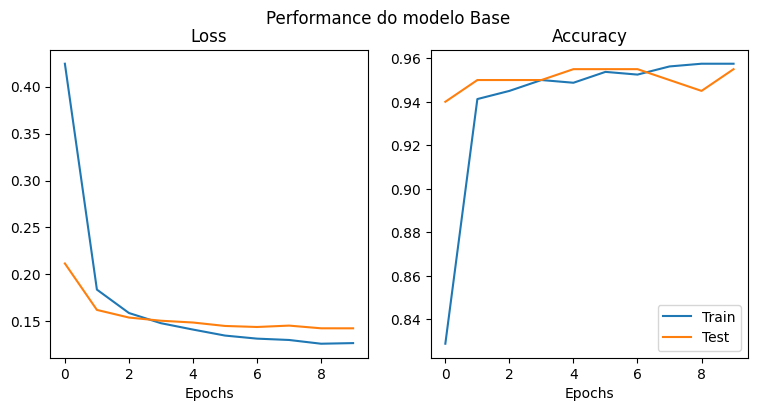

In [220]:
# exibindo performance do modelo base
plot_results(results = base_results)

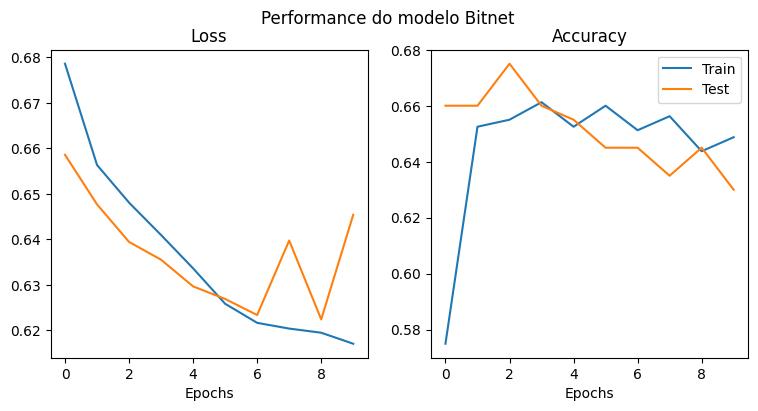

In [221]:
# exibindo performance do modelo bitnet
plot_results(results = bit_results)

In [222]:
def preds_to_classes(predictions: list, 
                     threshold = 0.5):
    classes = []
    for pred in predictions:
        if pred > threshold:
            classes.append(1)
        else:
            classes.append(0)
    return classes    

def evaluate_model(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   device: str = device) -> list:
    predictions = []

    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            logits = model(X.to(device))
            predictions += torch.round(torch.sigmoid(logits)).cpu()

    return predictions



def plot_comparison(  X, y,
                      baseline_model_name: str,
                      challenger_model_name: str, 
                      baseline_pred_classes: list,
                      challenger_pred_classes: list):

    # criado plot para comparar predicts dos modelos
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))        
    #fig.suptitle(f"Ground-Truth vs Model Predictions")
    # plotando ground-truth do dataloader
    ax1.scatter(x=X[:, 0], y=X[:, 1], c = y, cmap=plt.cm.RdYlBu)
    ax1.set_title("Ground-Truth")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    #plotando predicts do modelo base
    ax2.scatter(x=X[:, 0], y=X[:, 1], c = baseline_pred_classes, cmap=plt.cm.RdYlBu)
    ax2.set_title(f"{baseline_model_name} Predictions")
    # plotando predicts do modelo challenger
    ax3.scatter(x=X[:, 0], y=X[:, 1], c = challenger_pred_classes, cmap=plt.cm.RdYlBu)
    ax3.set_title(f"{challenger_model_name} Predictions")



In [223]:
# avaliando modelo base
baseline_pred_classes = evaluate_model(model = base_model, 
                                        dataloader=test_dataloader,
                                        device = device)
# avaliando modelo challenger
challenger_pred_classes = evaluate_model(model = bit_model, 
                                        dataloader=test_dataloader,
                                        device = device)



In [224]:
# plot_comparison(X_test, y_test,
#                 baseline_model_name = base_model.name,
#                 challenger_model_name = bit_model.name,
#                 baseline_pred_classes = baseline_pred_classes,
#                 challenger_pred_classes = challenger_pred_classes)

Baixando funções auxiliares para visualização das regiões de separação dos modelos

In [225]:
# Source: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


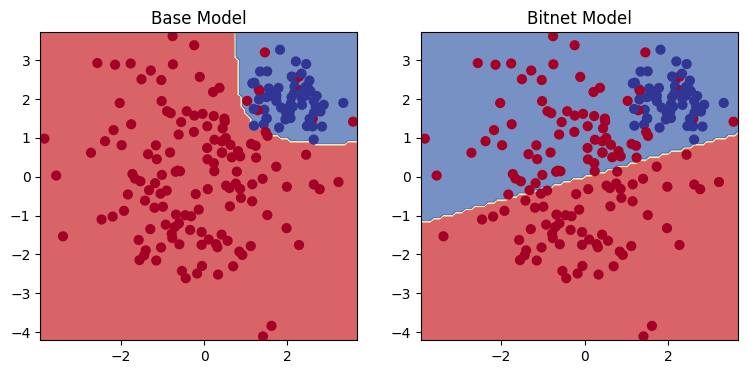

In [227]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title(f"{base_model.name} Model")
plot_decision_boundary(base_model, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title(f"{bit_model.name} Model")
plot_decision_boundary(bit_model, X_test, y_test)